In [9]:
ls

images/                         test_ETHUSDT_1h_indicators.pkl
LUNCBUSD_5m.pkl                 test_ETHUSDT_1h.pkl
LUNC-USDT_5m.pkl                test_ETHUSDT_4h.pkl
__pycache__/                    test_ETHUSDT_5m_indicators.pkl
signal_stat/                    test_ETHUSDT_5m.pkl
test_BTCUSDT_1d.pkl             test_find_signal.py
test_BTCUSDT_1h_indicators.pkl  test_get_data.py
test_BTCUSDT_1h.pkl             test_indicators.py
test_BTCUSDT_4h.pkl             test.ipynb
test_BTCUSDT_5m_indicators.pkl  test_signal_stat.py
test_BTCUSDT_5m.pkl             test_telegram_api.py
test_ETHUSDT_1d.pkl


In [15]:
pd.read_pickle('test_BTCUSDT_1h_indicators.pkl')

,time,open,high,low,close,volume,high_roll,low_roll
0,2022-07-22 12:00:00,23148.46,23227.44,23084.06,23166.26,5361.98846,NaN,NaN
1,2022-07-22 13:00:00,23166.26,23320.00,23015.00,23118.79,8487.13635,NaN,NaN
2,2022-07-22 14:00:00,23121.63,23320.00,23068.00,23301.73,9220.35704,23289.146667,23055.686667
3,2022-07-22 15:00:00,23304.92,23524.52,23262.72,23448.78,12244.08794,23388.173333,23115.240000
4,2022-07-22 16:00:00,23450.64,23590.56,23413.04,23438.05,6402.18281,23478.360000,23247.920000
...,...,...,...,...,...,...,...,...
496,2022-08-23 08:25:00,21288.33,21298.56,21275.49,21296.43,346.54270,21296.460000,21271.350000
497,2022-08-23 08:30:00,21297.28,21299.08,21277.99,21287.98,291.93010,21297.846667,21274.203333
498,2022-08-23 08:35:00,21288.42,21324.99,21281.40,21308.13,567.05334,21307.543333,21278.293333
499,2022-08-23 08:40:00,21308.13,21315.24,21291.23,21305.30,396.91497,21313.103333,21283.540000


In [4]:
import pandas as pd

lunc = pd.read_pickle('LUNCBUSD_5m.pkl')
lunc_okx = pd.read_pickle('LUNC-USDT_5m.pkl')

# Create test dataframe

In [1]:
import sys
sys.path.insert(0,'..')

import numpy as np
import pandas as pd
from datetime import datetime
from os import environ
from data.get_data import GetData
from data.get_data import DataFactory
from config.config import ConfigFactory
from signals.find_signal import FindSignal
from signal_stat.signal_stat import SignalStat
from visualizer.visualizer import Visualizer
from indicators.indicators import IndicatorFactory
from signals.find_signal import SignalFactory

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf

plt.style.use('ggplot')
matplotlib.use('NbAgg')

pd.set_option('display.max_rows', 500)

debug = False
# Set environment variable
environ["ENV"] = "test"
# Set dataframe dict
dfs = {'stat': {'buy': pd.DataFrame(columns=['time', 'ticker', 'timeframe']),
                'sell': pd.DataFrame(columns=['time', 'ticker', 'timeframe'])}}

# Get configs
configs = ConfigFactory.factory(environ).configs
       
# Set list of available exchanges, cryptocurrencies and tickers
exchanges = {'Binance': {'API': GetData(**configs), 'tickers': ['CRVUSDT']}}

# Get dict of exchange APIs
exchange_apis = dict()
for exchange in exchanges:
    exchange_api = DataFactory.factory(exchange, **configs)
    tickers = exchanges[exchange]['tickers']
    exchange_api.fill_ticker_dict(tickers)
    exchanges[exchange]['API'] = exchange_api

    # Higher timeframe from which we take levels
work_timeframe = configs['Timeframes']['work_timeframe']
    
# For every exchange, ticker and timeframe in base get cryptocurrency data and write it to correspond dataframe
for exchange, exchange_data in exchanges.items():
    exchange_api = exchange_data['API']
    tickers = exchange_data['tickers']
    timeframes = ['1h', '5m']
    for ticker in tickers:
        for timeframe in timeframes:
            print(f'Exchange is {exchange}, ticker is {ticker}, timeframe is {timeframe}')
            if debug:
                df = pd.read_pickle(f'test_{ticker}_{timeframe}.pkl')
                new_data_flag = True
            else:
                # If cryptocurrency dataframe is in dataframe dict - get it, else - create the new one
                df = dfs.get(ticker, dict()).get(timeframe, dict()).get('data', pd.DataFrame())
                # Write data to the dataframe
                df, data_qty = exchange_api.get_data(df, ticker, timeframe)
            # Create indicator list from search signal patterns list, if has new data and
            # data not from higher timeframe, else get only levels
            if data_qty > 1:
                indicators = list()
                if timeframe == work_timeframe:
                    indicator_list = configs['Indicator_list']
                else:
                    indicator_list = ['SUP_RES']
                for indicator in indicator_list:
                    ind_factory = IndicatorFactory.factory(indicator, configs)
                    if ind_factory:
                        indicators.append(ind_factory)
                # Write indicators to dataframe, update dataframe dict
                dfs, df = exchange_api.add_indicator_data(dfs, df, indicators, ticker, timeframe, configs)
                # Get signals
                if timeframe == work_timeframe:
                    fs = FindSignal(configs)
                    levels = dfs[ticker][timeframe]['levels']
                    points = fs.find_signal(df, ticker, timeframe, levels, data_qty)
                    # Write statistics
                    ss = SignalStat(**configs)
                    dfs = ss.write_stat(dfs, points)
                    
points

Exchange is Binance, ticker is CRVUSDT, timeframe is 1h
Exchange is Binance, ticker is CRVUSDT, timeframe is 5m


[('CRVUSDT',
  '5m',
  816,
  'sell',
  Timestamp('2022-09-06 02:15:00'),
  [('STOCH', (15, 85)), ('RSI', (25, 75))],
  [],
  [],
  [],
  []),
 ('CRVUSDT',
  '5m',
  823,
  'sell',
  Timestamp('2022-09-06 02:50:00'),
  [('STOCH', (15, 85)), ('RSI', (25, 75))],
  [],
  [],
  [],
  []),
 ('CRVUSDT',
  '5m',
  832,
  'sell',
  Timestamp('2022-09-06 03:35:00'),
  [('STOCH', (15, 85)), ('RSI', (25, 75))],
  [],
  [],
  [],
  [])]

# Test create_plot method of Vizualizer class

<IPython.core.display.Javascript object>


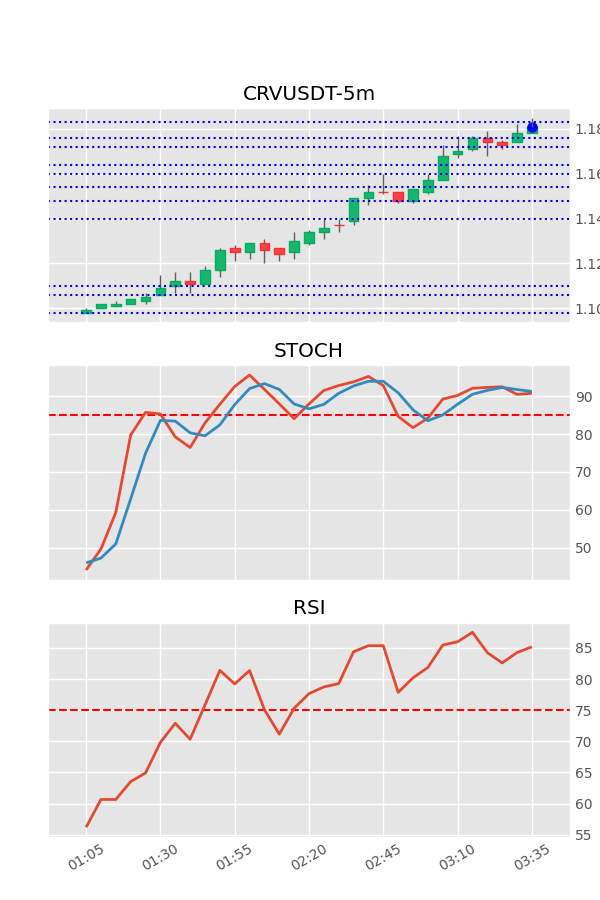

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf
import matplotlib.style as style

# style.use('fivethirtyeight') 

class Visualizer:
    type = 'Visualizer'

    def __init__(self, **params):
        self.params = params[self.type]['params']
        # Path to save plot files
        self.image_path = self.params['image_path']
        self.indicator_params = params['Indicator_signal']
        self.plot_width = self.params.get('plot_width', 10)
        self.indicator_dict = self.params.get('indicator_dict', dict())
        self.level_indicators = self.params.get('level_indicators', list())
        self.boundary_indicators = self.params.get('boundary_indicators', list())
        # Max number of previous candles for which signal can be searched for
        self.max_prev_candle_limit = self.params.get('max_prev_candle_limit', 0)

    def plot_indicator_parameters(self, point_type, index, indicator, axs, indicator_params):
        """ Plot parameters of indicator (like low or high boundary, etc.)"""
        indicator_param = indicator_params[index]
        if indicator_param:
            if indicator in self.boundary_indicators:
                if point_type == 'buy':
                    axs[index + 1].axhline(y=indicator_param[0], color='g', linestyle='--', linewidth=1.5)
                else:
                    axs[index + 1].axhline(y=indicator_param[1], color='r', linestyle='--', linewidth=1.5)

    def plot_point(self, point_type, data, ax):
        """ Plot trade point """
        if point_type == 'buy':
            ax.scatter(self.plot_width, data['close'].iloc[-1], s=50, color='blue')
        else:
            ax.scatter(self.plot_width, data['close'].iloc[-1], s=50, color='blue')

    @staticmethod
    def plot_levels(data, levels, axs):
        """ Plot support and resistance levels"""
        for level in levels:
            if data['low'].min() <= level[0] <= data['high'].max():  # and level[1] == 3:
                axs[0].axhline(y=level[0], color='b', linestyle='dotted', linewidth=1.5)

    def save_plot(self, ticker, timeframe, data):
        filename = f"{self.image_path}/{ticker}_{timeframe}_{data['time'].iloc[-1]}.png"
        plt.savefig(filename, bbox_inches='tight')
        return filename

    def create_plot(self, dfs, point, levels):
        # get necessary info
        ticker, timeframe, point_index, point_type, time, pattern, plot_path, exchange_list, x, y = point
        df = dfs[ticker][timeframe]['data']
        data = df.loc[point_index - self.plot_width:point_index]
        ohlc = data[['time', 'open', 'high', 'low', 'close', 'volume']]
        # get indicator list
        indicator_list = [p[0] for p in pattern if p[0] not in self.level_indicators]
        indicator_params = [p[1] for p in pattern if p not in self.level_indicators]
        plot_num = len(indicator_list) + 1

        # make subplots
        fig, axs = plt.subplots(plot_num, 1, figsize=(6, 3 * plot_num), sharex=True)
        ap = list()

        # plot candles
        ohlc = ohlc.set_index('time')

        for index, indicator in enumerate(indicator_list):
            # plot indicator
            indicator_columns = self.indicator_dict[indicator]
            for i_c in indicator_columns:
                m = mpf.make_addplot(data[i_c], panel=index + 1, title=indicator, ax=axs[index + 1], width=2)
                ap.append(m)
            # plot indicator parameters
            self.plot_indicator_parameters(point_type, index, indicator, axs, indicator_params)
            # plot y-labels from right side
            axs[index + 1].yaxis.set_label_position("right")
            axs[index + 1].yaxis.tick_right()

        # set x-labels
        axs[-1].set_xlabel(f"\n{data['time'].iloc[-1].date()}")
        plt.xticks(rotation=30)

        # plot all subplots
        mpf.plot(ohlc, type='candle', ax=axs[0], addplot=ap, warn_too_much_data=1001, style='yahoo',
                 axtitle=f'{ticker}-{timeframe}', ylabel='')

        # plot point of trade
        self.plot_point(point_type, data, axs[0])

        # plot levels
        self.plot_levels(data, levels, axs)

        # save plot to file
        filename = self.save_plot(ticker, timeframe, data)

        return filename
                
v = Visualizer(**configs)
levels = dfs['CRVUSDT']['5m']['levels']
v.create_plot(dfs, points[2], levels)
plt.show()

# Test higher_bound and low_bound methods for RSI indicator

This methods return True if at least two of three last indicator points are higher/lower than high/low bound for this indicator.

<IPython.core.display.Javascript object>


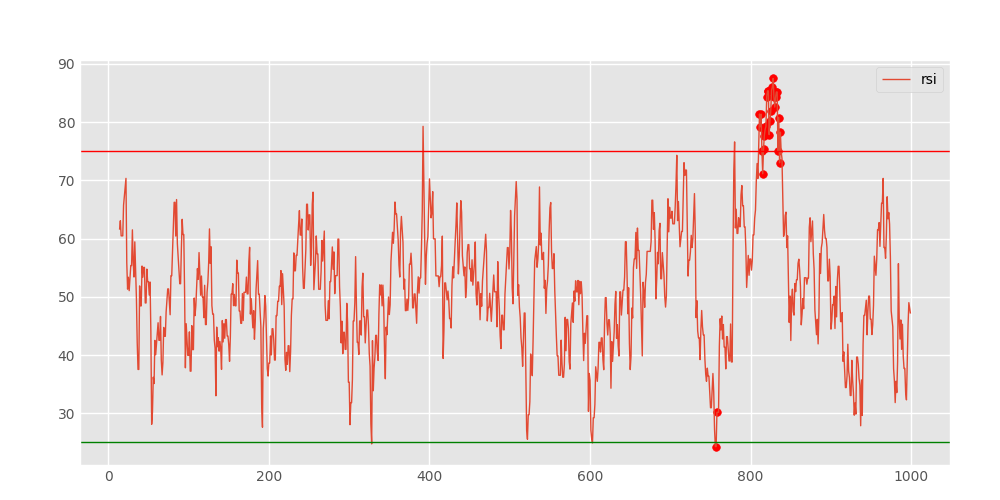

In [3]:
high_bound = 75
low_bound = 25

# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot RSI
ax.plot(df.loc[:, 'rsi'], linewidth=1)
ax.axhline(y=low_bound, color='g', linestyle='-', linewidth=1)
ax.axhline(y=high_bound, color='r', linestyle='-', linewidth=1)
leg = ax.legend(['rsi'])

# plot signal points
scatter_rsi_points = list()
rsi_sig = SignalFactory().factory('RSI', configs)

for index, row in df.iterrows():
    if index > 2:
        if rsi_sig.higher_bound(df['rsi'], index, high_bound) or rsi_sig.lower_bound(df['rsi'], index, low_bound):
            scatter_rsi_points.append((index, df.loc[index, 'rsi']))

for point in scatter_rsi_points:
    ax.scatter(point[0], point[1], s=30, color='red')
    
plt.show()

# Test up_direction and down_direction methods for STOCH indicator

This methods return True if indicator values increase/decrease.

In [19]:
flux

,time,open,high,low,close,volume,stoch_slowk,stoch_slowd,rsi,high_roll,low_roll,stoch_slowk_dir,stoch_slowd_dir,stoch_diff
0,2022-09-04 03:45:00,1.022,1.023,1.022,1.022,827.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2022-09-04 03:50:00,1.022,1.024,1.021,1.023,1380.34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2022-09-04 03:55:00,1.024,1.024,1.024,1.024,1443.99,NaN,NaN,NaN,1.023667,1.022333,NaN,NaN,NaN
3,2022-09-04 04:00:00,1.025,1.025,1.023,1.024,732.45,NaN,NaN,NaN,1.024333,1.022667,NaN,NaN,NaN
4,2022-09-04 04:05:00,1.025,1.025,1.025,1.025,576.43,NaN,NaN,NaN,1.024667,1.024000,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,2022-09-07 14:40:00,1.278,1.282,1.262,1.278,110800.63,24.574373,41.061828,43.567647,1.294667,1.276667,-0.315975,-0.198778,-18.926153
996,2022-09-07 14:45:00,1.281,1.282,1.253,1.253,84983.88,9.991039,22.632915,35.439439,1.288333,1.264333,-0.448522,-0.334933,-18.574415
997,2022-09-07 14:50:00,1.255,1.268,1.252,1.262,68336.66,13.231780,15.932397,39.794125,1.277333,1.255667,-0.177280,-0.353222,-10.609983
998,2022-09-07 14:55:00,1.263,1.266,1.263,1.264,5027.23,10.185185,11.136002,40.750539,1.272000,1.256000,-0.166440,-0.348636,-5.431103


<IPython.core.display.Javascript object>


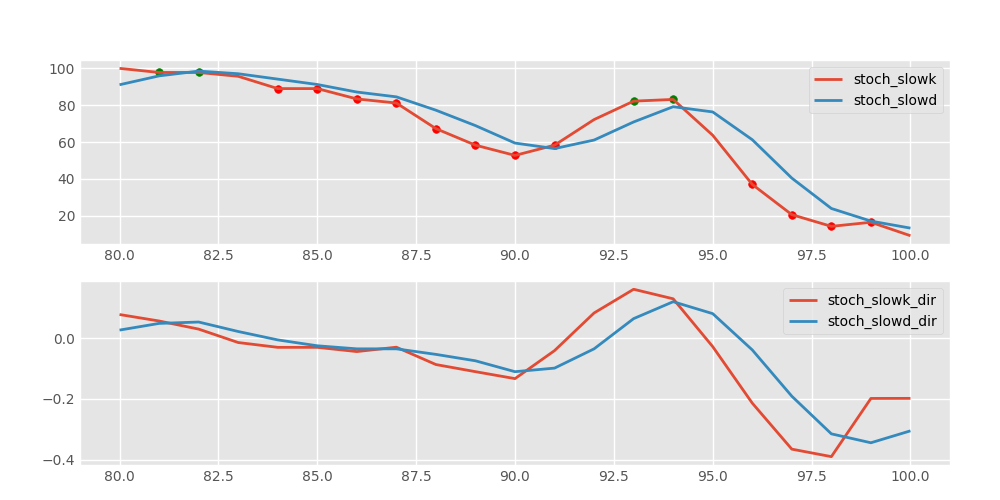

In [4]:
# subplots for STOCH
fig = plt.figure(figsize=(10, 5))
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2, sharex=ax1)

# plot STOCH
ax1.plot(df.loc[80:100, 'stoch_slowk'], linewidth=2)
ax1.plot(df.loc[80:100, 'stoch_slowd'], linewidth=2)
ax2.plot(df.loc[80:100, 'stoch_slowk_dir'], linewidth=2)
ax2.plot(df.loc[80:100, 'stoch_slowd_dir'], linewidth=2)
leg = ax1.legend(['stoch_slowk', 'stoch_slowd'])
leg = ax2.legend(['stoch_slowk_dir', 'stoch_slowd_dir'])

# plot signal points
scatter_stoch_points_up = list()
scatter_stoch_points_down = list()
stoch_sig = SignalFactory().factory('STOCH', configs)

for index, row in df.iterrows():
    if 80 < index < 100:
        if (stoch_sig.up_direction(df['stoch_slowk_dir'], index) and \
            stoch_sig.up_direction(df['stoch_slowd_dir'], index)):
            scatter_stoch_points_up.append((index, df.loc[index, 'stoch_slowk']))
        if (stoch_sig.down_direction(df['stoch_slowk_dir'], index) and \
            stoch_sig.down_direction(df['stoch_slowd_dir'], index)):
            scatter_stoch_points_down.append((index, df.loc[index, 'stoch_slowk']))

for point in scatter_stoch_points_up:
    ax1.scatter(point[0], point[1], s=30, color='green')

for point in scatter_stoch_points_down:
    ax1.scatter(point[0], point[1], s=30, color='red')
    
plt.show()

# Test crossed_lines method for STOCH indicator

This methods return True if two lines of indicator has crossed (for previous or pre-previous values).

<IPython.core.display.Javascript object>


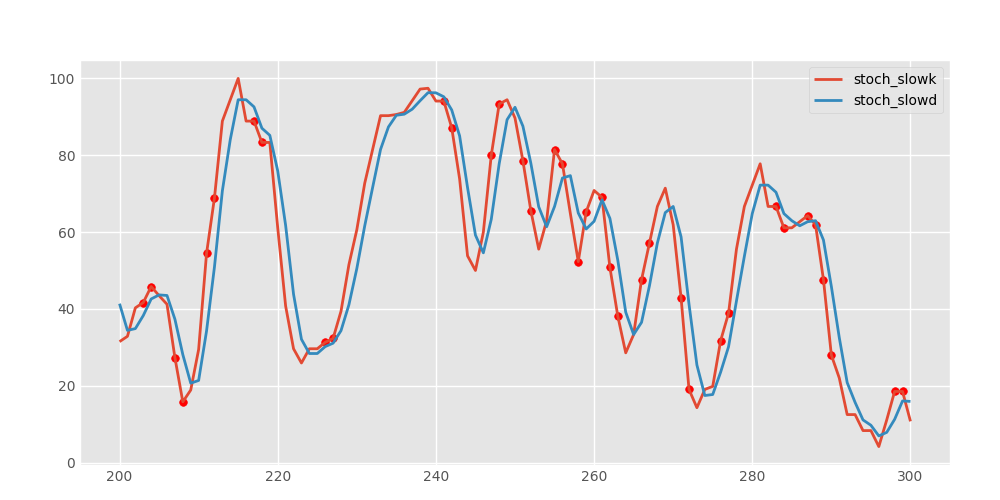

In [5]:
# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot STOCH
ax.plot(df.loc[200:300, 'stoch_slowk'], linewidth=2)
ax.plot(df.loc[200:300, 'stoch_slowd'], linewidth=2)
leg = ax.legend(['stoch_slowk', 'stoch_slowd'])

# plot signal points
scatter_stoch_points = list()
stoch_sig = SignalFactory().factory('STOCH', configs)

for index, row in df.iterrows():
    if 200 < index < 300:
        if stoch_sig.crossed_lines(df['stoch_diff'], index, True) or \
           stoch_sig.crossed_lines(df['stoch_diff'], index, False):
            scatter_stoch_points.append((index, df.loc[index, 'stoch_slowk']))

for point in scatter_stoch_points:
    ax.scatter(point[0], point[1], s=30, color='red')
    
plt.show()

# Test find_stoch_signal method for STOCH indicator

This methods return True if STOCH indicator is in overbuy/oversell zone, slowk and slowd lines has crossed and both changed their direction.

<IPython.core.display.Javascript object>


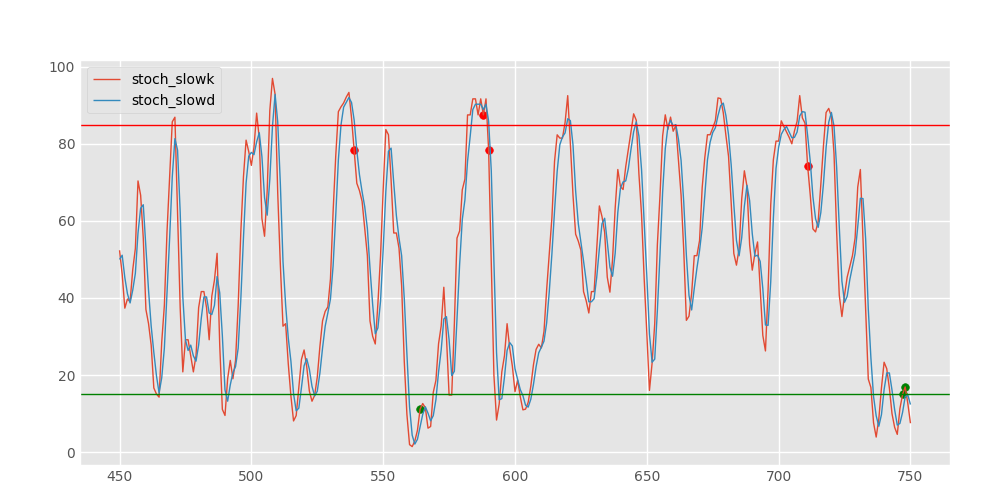

In [6]:
# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot STOCH
high_bound = 85
low_bound = 15
ax.plot(df.loc[450:750, 'stoch_slowk'], linewidth=1)
ax.plot(df.loc[450:750, 'stoch_slowd'], linewidth=1)
ax.axhline(y=low_bound, color='g', linestyle='-', linewidth=1)
ax.axhline(y=high_bound, color='r', linestyle='-', linewidth=1)
leg = ax.legend(['stoch_slowk', 'stoch_slowd'])

# plot signal points
scatter_stoch_points_buy = list()
scatter_stoch_points_sell = list()
stoch_sig = SignalFactory().factory('STOCH', configs)

for index, row in df.iterrows():
    if 450 < index < 750:
        fs = stoch_sig.find_signal(df, index)
        if fs[0]:
            if fs[1] == 'buy':
                scatter_stoch_points_buy.append((index, df.loc[index, 'stoch_slowk']))
            else:
                scatter_stoch_points_sell.append((index, df.loc[index, 'stoch_slowk']))

for point in scatter_stoch_points_buy:
    ax.scatter(point[0], point[1], s=30, color='green')
    
for point in scatter_stoch_points_sell:
    ax.scatter(point[0], point[1], s=30, color='red')
    
plt.show()

# Test check_levels method for SUP_RES indicator

This methods return True if price is near support level for the buy trade and near resistance level for the sell trade.

<IPython.core.display.Javascript object>


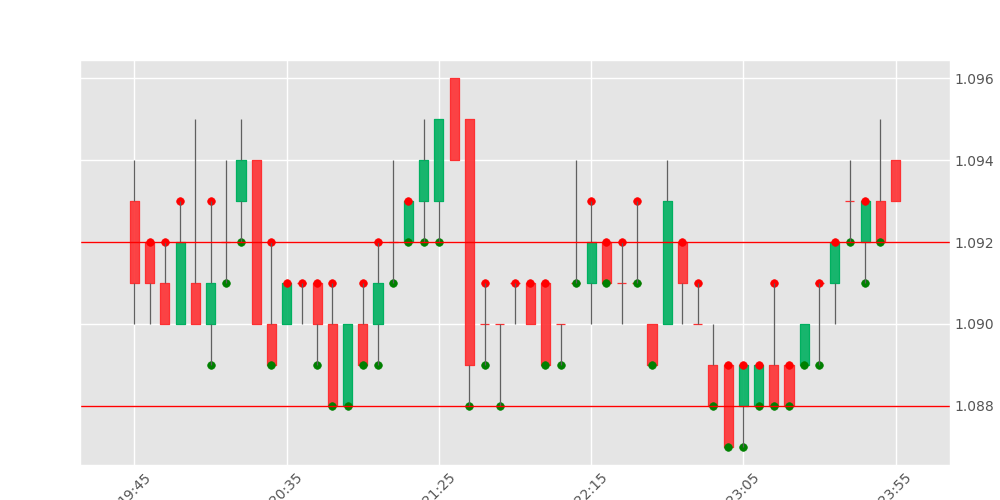

In [7]:
low_bound = 450
high_bound = 500

sup_res_sig = SignalFactory().factory('SUP_RES', configs)
# levels = dfs['ETHUSDT']['5m']['levels']
levels = dfs['CRVUSDT']['5m']['levels']
level_proximity = np.mean(df['high'] - df['low']) * sup_res_sig.proximity_multiplier

# subplots for RSI
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax, warn_too_much_data=10000, style='yahoo')

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()

# get signal points
for index, row in df.iterrows():
    for buy in [False, True]:
        if low_bound < index < high_bound:
            fs = sup_res_sig.check_levels(df, index, levels, level_proximity, buy)
            if fs:
                if buy:
                    scatter_candle_points_buy.append((index, df.loc[index, 'low']))
                else:
                    scatter_candle_points_sell.append((index, df.loc[index, 'high']))

for point in scatter_candle_points_buy:
    ax.scatter(point[0]-low_bound, point[1], s=30, color='green')
    
for point in scatter_candle_points_sell:
    ax.scatter(point[0]-low_bound, point[1], s=30, color='red')
    
# plot levels
for level in levels:
    if df.loc[low_bound:high_bound, 'low'].min() <= level[0] <= df.loc[low_bound:high_bound, 'high'].max():
        ax.axhline(y=level[0], color='r', linestyle='-', linewidth=1)
        
plt.show()

# Test find_signal method of FindSignal class 

Parameters: (BTCUSDT, 5m, pattern: (STOCH, RSI))

<IPython.core.display.Javascript object>


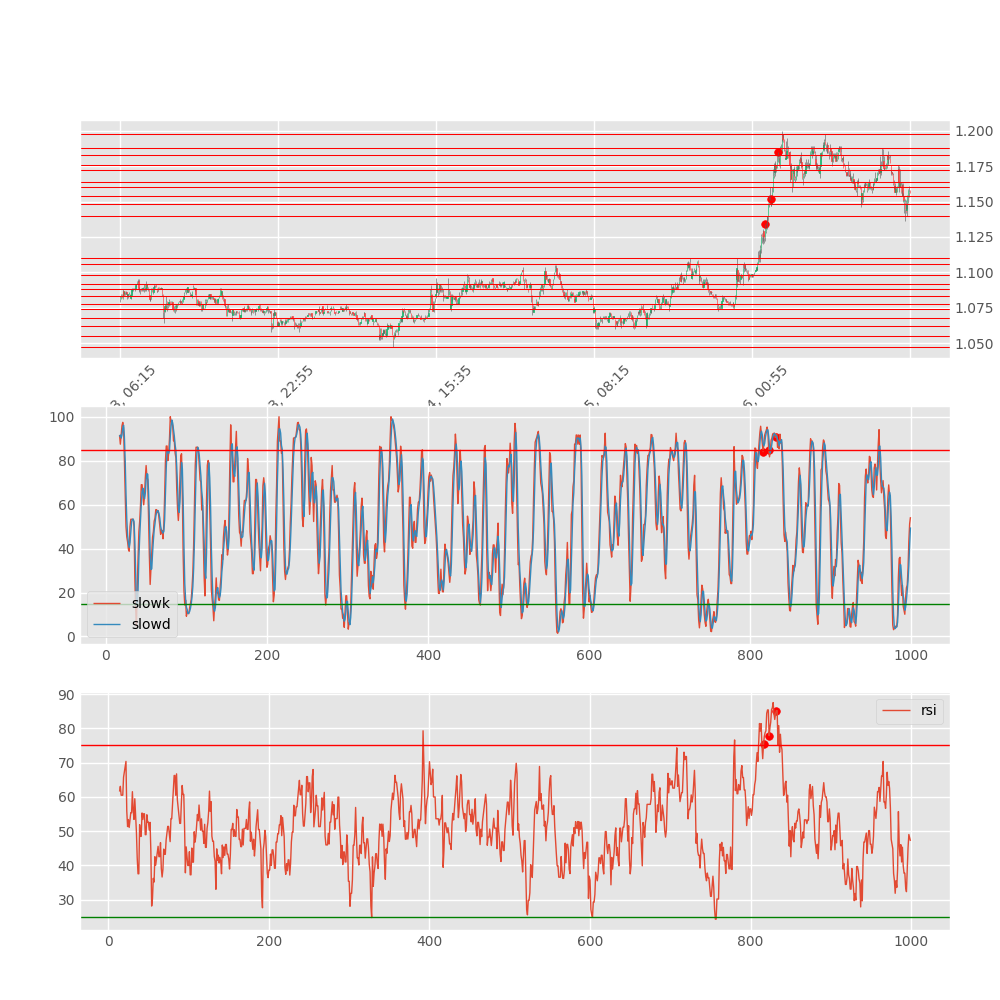

In [9]:
import mplfinance as mpf

low_bound = 0
high_bound = 1000

pd.set_option('display.max_rows', 500)

# find signal points
fs = FindSignal(configs)
fs.patterns = [['STOCH', 'RSI']]
df = dfs['CRVUSDT']['5m']['data']
levels = dfs['CRVUSDT']['5m']['levels']
data_qty = 1000
points = fs.find_signal(df, 'CRVUSDT', '5m', levels, data_qty)

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo')

# plot STOCH
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowk'], linewidth=1)
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowd'], linewidth=1)
# show boundaries
ax2.axhline(y=15, color='g', linestyle='-', linewidth=1)
ax2.axhline(y=85, color='r', linestyle='-', linewidth=1)
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(df.loc[low_bound:high_bound, 'rsi'], linewidth=1)
# show boundaries
ax3.axhline(y=25, color='g', linestyle='-', linewidth=1)
ax3.axhline(y=75, color='r', linestyle='-', linewidth=1)
leg = ax3.legend(['rsi'])

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    if point[1] == 'buy':
        scatter_candle_points_buy.append((point[2], df.loc[point[2], 'low']))
    else:
        scatter_candle_points_sell.append((point[2], df.loc[point[2], 'high']))
    scatter_stoch_points.append((point[2], df.loc[point[2], 'stoch_slowk']))
    scatter_rsi_points.append((point[2], df.loc[point[2], 'rsi']))


for point in scatter_candle_points_buy:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='green')
        
for point in scatter_candle_points_sell:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_stoch_points:
    if low_bound < point[0] < high_bound:
        ax2.scatter(point[0], point[1], s=30, color='red')
        
for point in scatter_rsi_points:
    if low_bound < point[0] < high_bound:
        ax3.scatter(point[0], point[1], s=30, color='red')

# plot levels
for level in levels:
    if df.loc[low_bound:high_bound, 'low'].min() <= level[0] <= df.loc[low_bound:high_bound, 'high'].max():
        ax1.axhline(y=level[0], color='r', linestyle='-', linewidth=0.75)
        
plt.show()

# Test find_signal method of FindSignal class 

Parameters: (BTCUSDT, 5m, pattern: (STOCH, RSI, SUP_RES))

<IPython.core.display.Javascript object>


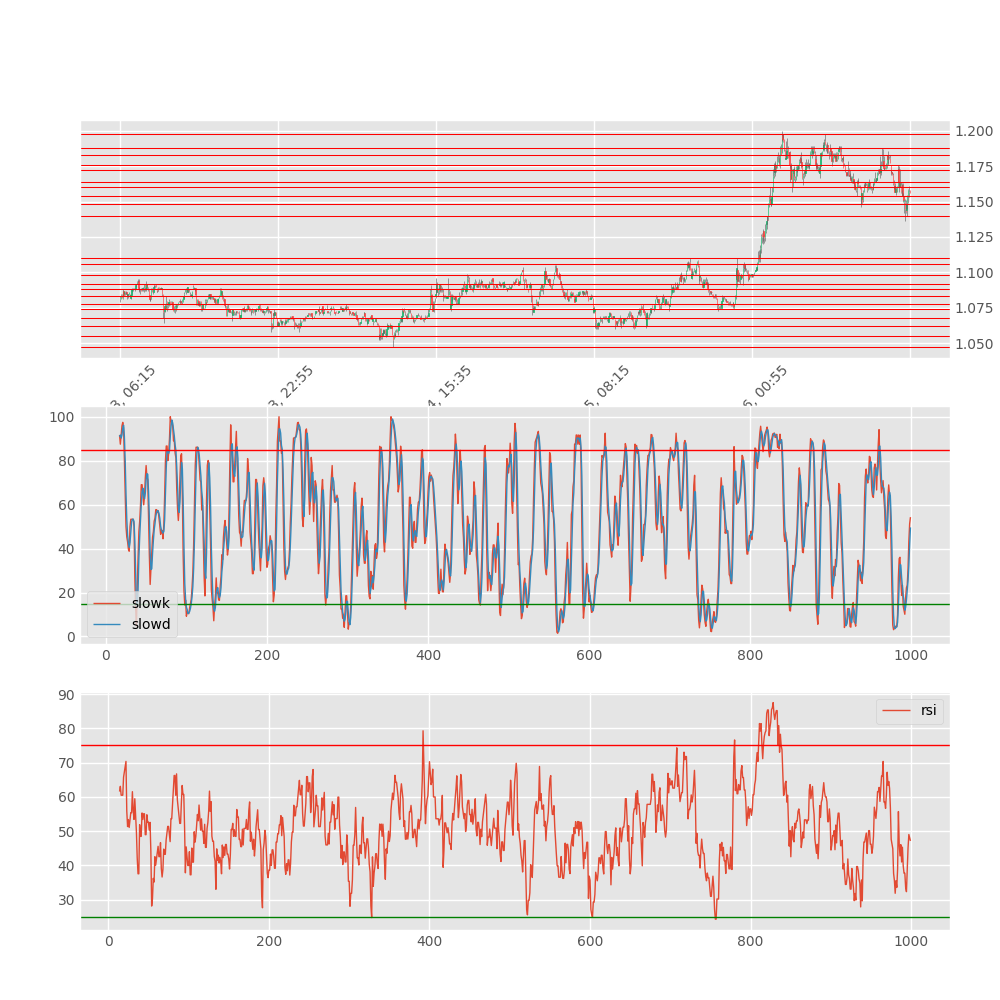

In [8]:
import mplfinance as mpf

low_bound = 0
high_bound = 1000

pd.set_option('display.max_rows', 500)

# find signal points
fs = FindSignal(configs)
fs.patterns = [['STOCH', 'RSI', 'SUP_RES']]
df = dfs['CRVUSDT']['5m']['data']
levels = dfs['CRVUSDT']['5m']['levels']
data_qty = 1000
points = fs.find_signal(df, 'CRVUSDT', '5m', levels, data_qty)

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo')

# plot STOCH
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowk'], linewidth=1)
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowd'], linewidth=1)
# show boundaries
ax2.axhline(y=15, color='g', linestyle='-', linewidth=1)
ax2.axhline(y=85, color='r', linestyle='-', linewidth=1)
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(df.loc[low_bound:high_bound, 'rsi'], linewidth=1)
# show boundaries
ax3.axhline(y=25, color='g', linestyle='-', linewidth=1)
ax3.axhline(y=75, color='r', linestyle='-', linewidth=1)
leg = ax3.legend(['rsi'])

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    if point[3] == 'buy':
        scatter_candle_points_buy.append((point[2], df.loc[point[2], 'low']))
    else:
        scatter_candle_points_sell.append((point[2], df.loc[point[2], 'high']))
    scatter_stoch_points.append((point[2], df.loc[point[2], 'stoch_slowk']))
    scatter_rsi_points.append((point[2], df.loc[point[2], 'rsi']))


for point in scatter_candle_points_buy:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='green')
        
for point in scatter_candle_points_sell:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_stoch_points:
    if low_bound < point[0] < high_bound:
        ax2.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_rsi_points:
    if low_bound < point[0] < high_bound:
        ax3.scatter(point[0]-low_bound, point[1], s=30, color='red')

# plot levels
for level in levels:
    if df.loc[low_bound:high_bound, 'low'].min() <= level[0] <= df.loc[low_bound:high_bound, 'high'].max():
        ax1.axhline(y=level[0], color='r', linestyle='-', linewidth=0.75)
        
plt.show()

# Test find_signal method of FindSignal class 

Parameters: (ETHUSDT, 5m, pattern: (STOCH, RSI))

<IPython.core.display.Javascript object>


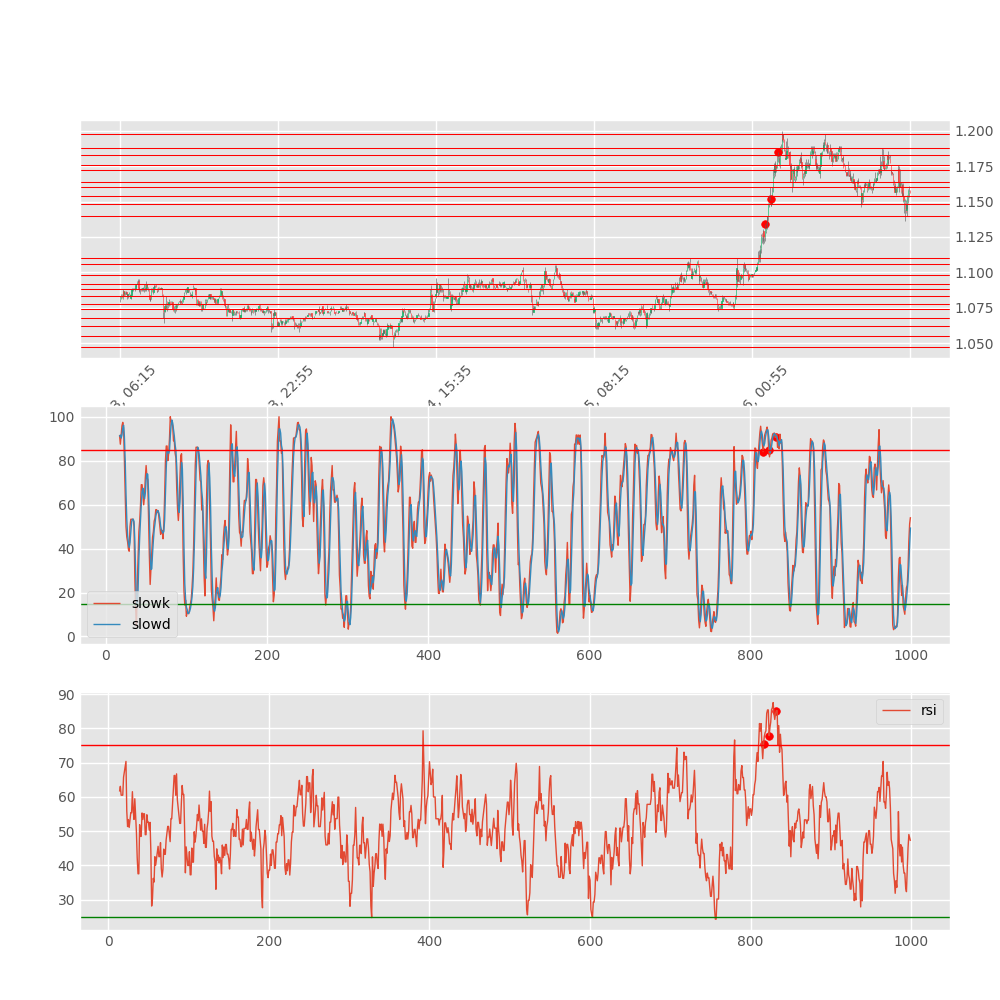

In [10]:
low_bound = 0
high_bound = 1000

pd.set_option('display.max_rows', 500)

# find signal points
fs = FindSignal(configs)
fs.patterns = [['STOCH', 'RSI']]
df = dfs['CRVUSDT']['5m']['data']
levels = dfs['CRVUSDT']['5m']['levels']
data_qty = 1000
points = fs.find_signal(df, 'CRVUSDT', '5m', levels, data_qty)

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo')

# plot STOCH
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowk'], linewidth=1)
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowd'], linewidth=1)
# show boundaries
ax2.axhline(y=15, color='g', linestyle='-', linewidth=1)
ax2.axhline(y=85, color='r', linestyle='-', linewidth=1)
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(df.loc[low_bound:high_bound, 'rsi'], linewidth=1)
# show boundaries
ax3.axhline(y=25, color='g', linestyle='-', linewidth=1)
ax3.axhline(y=75, color='r', linestyle='-', linewidth=1)
leg = ax3.legend(['rsi'])

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    if point[1] == 'buy':
        scatter_candle_points_buy.append((point[2], df.loc[point[2], 'low']))
    else:
        scatter_candle_points_sell.append((point[2], df.loc[point[2], 'high']))
    scatter_stoch_points.append((point[2], df.loc[point[2], 'stoch_slowk']))
    scatter_rsi_points.append((point[2], df.loc[point[2], 'rsi']))


for point in scatter_candle_points_buy:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='green')
        
for point in scatter_candle_points_sell:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_stoch_points:
    if low_bound < point[0] < high_bound:
        ax2.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_rsi_points:
    if low_bound < point[0] < high_bound:
        ax3.scatter(point[0]-low_bound, point[1], s=30, color='red')

# plot levels
for level in levels:
    if df.loc[low_bound:high_bound, 'low'].min() <= level[0] <= df.loc[low_bound:high_bound, 'high'].max():
        ax1.axhline(y=level[0], color='r', linestyle='-', linewidth=0.75)
        
plt.show()

# Test find_signal method of FindSignal class 

Parameters: (ETHUSDT, 5m, pattern: (STOCH, RSI, SUP_RES))

<IPython.core.display.Javascript object>


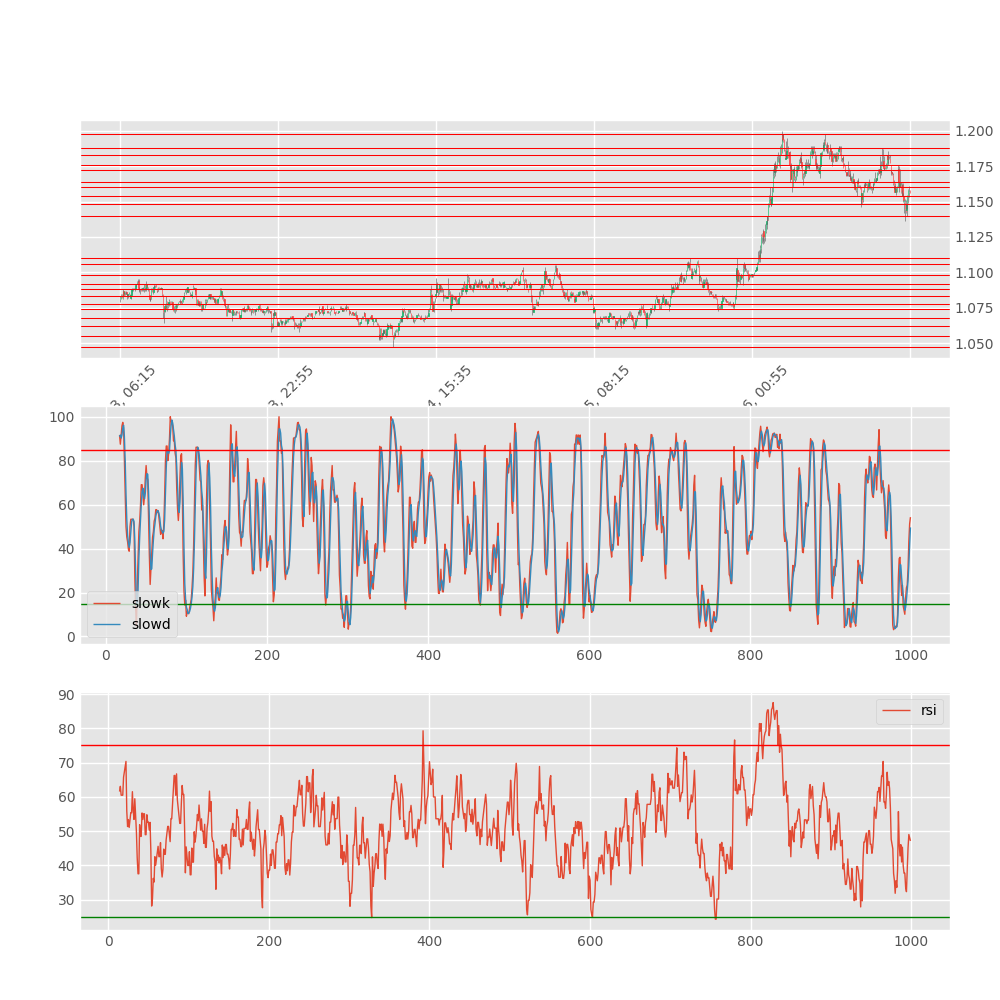

In [11]:
low_bound = 0
high_bound = 1000

pd.set_option('display.max_rows', 500)

# find signal points
fs = FindSignal(configs)
fs.patterns = [['STOCH', 'RSI', 'SUP_RES']]
df = dfs['CRVUSDT']['5m']['data']
levels = dfs['CRVUSDT']['5m']['levels']
data_qty = 1000
points = fs.find_signal(df, 'CRVUSDT', '5m', levels, data_qty)

# subplots for STOCH and RSI
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 10))

# plot candles
ohlc = df.loc[low_bound:high_bound, ['time', 'open', 'high', 'low', 'close', 'volume']]
ohlc = ohlc.set_index('time')
mpf.plot(ohlc, type='candle', ax=ax1, warn_too_much_data=10000, style='yahoo')

# plot STOCH
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowk'], linewidth=1)
ax2.plot(df.loc[low_bound:high_bound, 'stoch_slowd'], linewidth=1)
# show boundaries
ax2.axhline(y=15, color='g', linestyle='-', linewidth=1)
ax2.axhline(y=85, color='r', linestyle='-', linewidth=1)
leg = ax2.legend(['slowk', 'slowd'])

# plot RSI
ax3.plot(df.loc[low_bound:high_bound, 'rsi'], linewidth=1)
# show boundaries
ax3.axhline(y=25, color='g', linestyle='-', linewidth=1)
ax3.axhline(y=75, color='r', linestyle='-', linewidth=1)
leg = ax3.legend(['rsi'])

# plot signal points
scatter_candle_points_buy = list()
scatter_candle_points_sell = list()
scatter_stoch_points = list()
scatter_rsi_points = list()

for point in points:
    if point[1] == 'buy':
        scatter_candle_points_buy.append((point[2], df.loc[point[2], 'low']))
    else:
        scatter_candle_points_sell.append((point[2], df.loc[point[2], 'high']))
    scatter_stoch_points.append((point[2], df.loc[point[2], 'stoch_slowk']))
    scatter_rsi_points.append((point[2], df.loc[point[2], 'rsi']))


for point in scatter_candle_points_buy:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='green')
        
for point in scatter_candle_points_sell:
    if low_bound < point[0] < high_bound:
        ax1.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_stoch_points:
    if low_bound < point[0] < high_bound:
        ax2.scatter(point[0]-low_bound, point[1], s=30, color='red')
        
for point in scatter_rsi_points:
    if low_bound < point[0] < high_bound:
        ax3.scatter(point[0]-low_bound, point[1], s=30, color='red')

# plot levels
for level in levels:
    if df.loc[low_bound:high_bound, 'low'].min() <= level[0] <= df.loc[low_bound:high_bound, 'high'].max():
        ax1.axhline(y=level[0], color='r', linestyle='-', linewidth=0.75)
        
plt.show()